# 2. Data fetching and processing

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

## More details about list_data

In [3]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_remote_model

In [4]:
model_list = list_models(organism="human")

In [5]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
1,Human-GEM,Homo sapiens,13070,8369,3067,metabolic atlas
1,iAB_RBC_283,Homo sapiens,469,342,346,BiGG
12,iAT_PLT_636,Homo sapiens,1008,738,636,BiGG
105,RECON1,Homo sapiens,3741,2766,1905,BiGG
106,Recon3D,Homo sapiens,10600,5835,2248,BiGG


In [6]:
# select by number of components

model_list = list_models(organism="mouse", 
                         max_n_genes=2000, max_n_mets=3000, max_n_rxns=5000)

In [7]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
77,iMM1415,Mus musculus,3726,2775,1375,BiGG


## Generate simulated gene data

In [8]:
from pipeGEM.data.synthesis import get_syn_gene_data
import seaborn as sns
import numpy as np

In [9]:
mouse = load_remote_model('iMM1415')

Output()

No objective coefficients in model. Unclear what should be optimized


In [10]:
raw_count = get_syn_gene_data(mouse, n_sample=9, random_state=42)

In [11]:
raw_count.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,1461,1467,1511,1451,1455,1502,1359,1455,1481
67689,2520,2425,2448,2505,2387,2444,2479,2408,2319
237940,12245,11857,11953,12095,12054,11849,12323,12163,11762
222,832,807,825,823,840,845,919,798,860
76507,30289,30916,30368,31428,30924,30584,30503,30198,30589


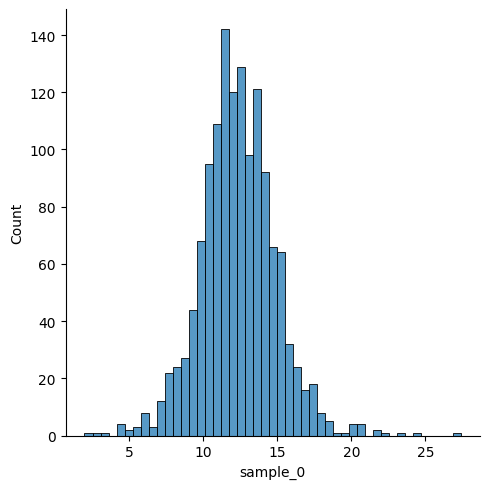

In [12]:
sns.displot(np.log2(raw_count + 1)["sample_0"])

## Maping gene data to a pipeGEM model

In [13]:
from pipeGEM.data import GeneData

In [17]:
p_mouse = pg.Model("imm1415", mouse)

In [18]:
gene_data = GeneData(data=raw_count["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=0)

In [19]:
p_mouse.add_gene_data(name_or_prefix="sample_0", 
                      data=gene_data, 
                      or_operation="nanmax",  # alternative: nansum
                      threshold=-np.inf, 
                      absent_value=-np.inf)

100%|███████████████████████████████████████████████████████████████████████████| 3726/3726 [00:00<00:00, 12051.50it/s]

Finished mapping in 0.3420863151550293 seconds.


In [20]:
p_mouse.reactions.get_by_id("2HBt2")

Reaction identifier,2HBt2
Name,2 hydroxybutyrate cotransport with proton
Memory address,0x1b79f92f8b0
Stoichiometry,2hb_e + h_e <=> 2hb_c + h_c 2 Hydroxybutyrate C4H7O3 + H+ <=> 2 Hydroxybutyrate C4H7O3 + H+
GPR,80879 or 20503 or 20501
Lower bound,-100000.0
Upper bound,100000.0


In [21]:
p_mouse.gene_data["sample_0"].rxn_scores["2HBt2"]

15.077358175436048

In [22]:
gene_data.transformed_gene_data["80879"], gene_data.transformed_gene_data["20503"], gene_data.transformed_gene_data["20501"]

(12.262388523751019, 14.023407843140218, 15.077358175436048)

## Finding data thresholds

In [23]:
# modified rFASTCORMICS thresholds
rFASTCORMICS_threshold = gene_data.get_threshold("rFASTCORMICS", return_heuristic=False)

p_score of init values: 0.05166682619379623
original guess:  10.2725845924854 13.87628153509947
best fitted Amps:  0.14863768215360654 0.03174552227686612
best fitted means:  12.51202902321045 11.26317542557138


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\analysis\_threshold.py:158: UserWarning: Fail to find proper parameters, return the best 3 params
  warnings.warn(f"Fail to find proper parameters, return the best {k} params")


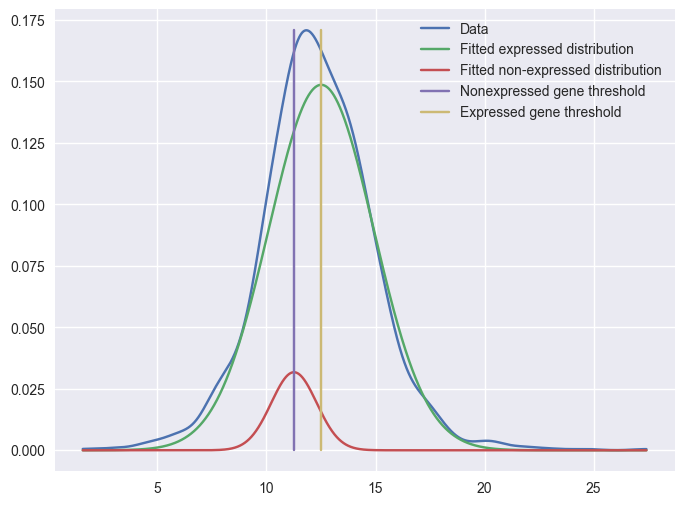

Expression threshold: 12.51202902321045


In [24]:
rFASTCORMICS_threshold.plot()
print(f"Expression threshold: {rFASTCORMICS_threshold.exp_th}")

In [25]:
# percentile thresholds
p90_threshold = gene_data.get_threshold("percentile", p=90)
p75_threshold = gene_data.get_threshold("percentile", p=75)
p50_threshold = gene_data.get_threshold("percentile", p=50)

In [26]:
p50_threshold.exp_th, p75_threshold.exp_th, p90_threshold.exp_th

(12.282798858683533, 13.881009769447015, 15.35267145440937)

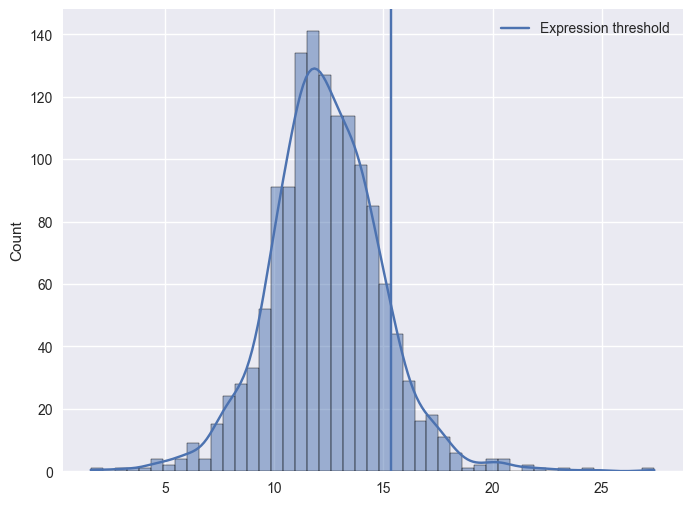

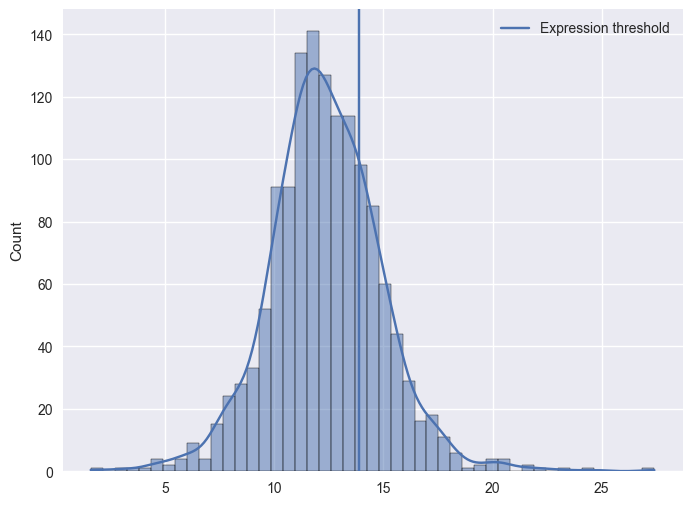

In [27]:
p90_threshold.plot()
p75_threshold.plot()

## Visualizing gene data

In [28]:
gene_data_dict = {k: GeneData(data=v, 
                              data_transform=lambda x: np.log2(x), 
                              absent_expression=-np.inf) 
                  for k, v in raw_count.items()}

In [29]:
gene_data_dict

{'sample_0': <pipeGEM.data.data.GeneData at 0x1b7b99b0f10>,
 'sample_1': <pipeGEM.data.data.GeneData at 0x1b7b99b05b0>,
 'sample_2': <pipeGEM.data.data.GeneData at 0x1b7b99b01f0>,
 'sample_3': <pipeGEM.data.data.GeneData at 0x1b7b99b0310>,
 'sample_4': <pipeGEM.data.data.GeneData at 0x1b7b99b1240>,
 'sample_5': <pipeGEM.data.data.GeneData at 0x1b7b99b0400>,
 'sample_6': <pipeGEM.data.data.GeneData at 0x1b7b550ff40>,
 'sample_7': <pipeGEM.data.data.GeneData at 0x1b7b99f6d40>,
 'sample_8': <pipeGEM.data.data.GeneData at 0x1b7b9a09270>}

In [30]:
agg_data = GeneData.aggregate(gene_data_dict, prop="data")

In [31]:
corr_result = agg_data.corr()

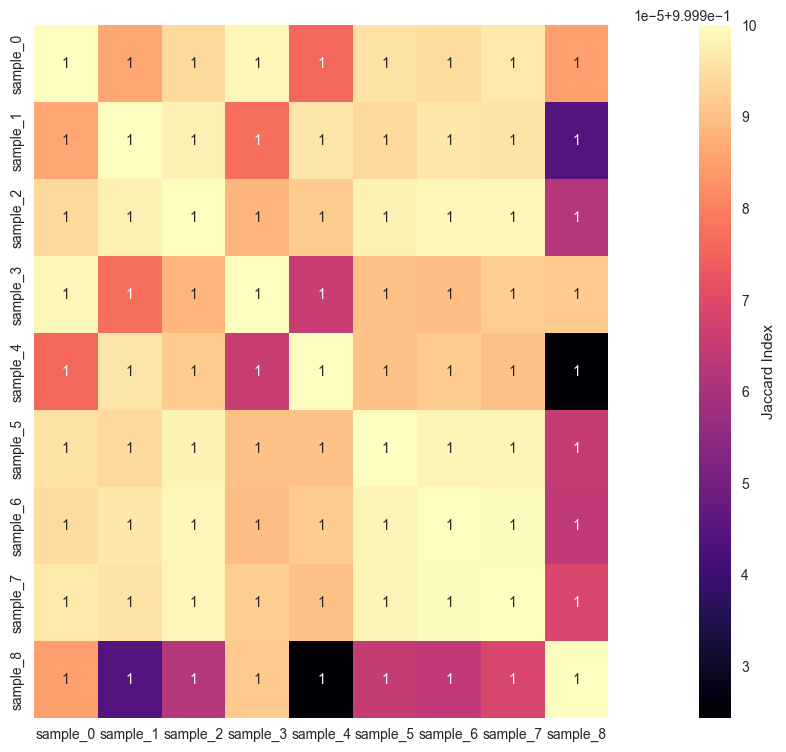

In [32]:
corr_result.plot()

In [37]:
agg_data

           sample_0  sample_1  sample_2  sample_3  sample_4  sample_5  \
100039108      2038    2127.0      2131      1993      1974      2060   
100041375     26814   28565.0     27612     28233     27654     27167   
100042918      6390    6406.0      6300      6626      6411      6507   
100043349      7807    7959.0      8055      7923      7858      7845   
100043472      5752    5702.0      5709      5584      5685      5777   
...             ...       ...       ...       ...       ...       ...   
99439           171     181.0       162       152       181       157   
9952           4010    4115.0      4243      4284      4012      4046   
9954           4028    3868.0      4056      4097      4065      3925   
99586           195     214.0       201       209       198       228   
99712          4116    4027.0      4051      4232      4112      4058   

           sample_6  sample_7  sample_8  
100039108      2042      1997      2071  
100041375     27972     27790     27702

In [35]:
pca_result = agg_data.dim_reduction(method="PCA")

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
pca_result.plot()

In [36]:
tsne_result = agg_data.dim_reduction(method="TSNE")
tsne_result.plot()

ValueError: Input X contains infinity or a value too large for dtype('float64').

C:\Users\qwert\miniconda3\envs\py38\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


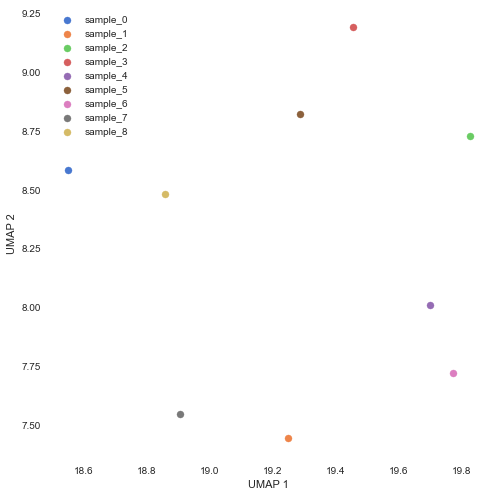

In [37]:
tsne_result = agg_data.dim_reduction(method="UMAP")
tsne_result.plot()

## Medium data

In [7]:
human = load_remote_model("Human-GEM")

Model Human-GEM is already downloaded
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


In [8]:
human.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
MAM01291e,MAR00566,0.3888,22,0.01%
MAM01771e,MAR00567,0.01104,20,0.00%
MAM01371e,MAR00569,1000,10,10.44%
MAM01741e,MAR00571,0.1629,22,0.00%
MAM01689e,MAR00573,0.4173,22,0.01%
MAM00094e,MAR00575,0.1049,22,0.00%
MAM01696e,MAR00576,3.583,20,0.07%
MAM02648e,MAR00577,0.6377,20,0.01%
MAM01432e,MAR00618,0.01104,26,0.00%
MAM02456e,MAR00620,0.01104,17,0.00%
